![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Advanced Methods in Natural Language Processing - Session 4

# Text Classification with AG News Corpus

This notebook will guide you through different approaches to text classification using the AG News corpus. We will start with a simple baseline model and gradually move towards more complex and sophisticated models.

## Table of Contents

1. **[Part 1: Baseline Pipeline with TF-IDF and Linear Model](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Feature Extraction with TF-IDF
   - 1.3. Training a Linear Model
   - 1.4. Model Evaluation

2. **[Part 2: LSTM Pipeline with One-Hot Encoding](#part2)**
   - 2.1. Preprocessing for LSTM
   - 2.2. Building a Bidirectional LSTM Model
   - 2.3. Training the LSTM Model
   - 2.4. Model Evaluation

3. **[Part 3: Word Embedding Add-Ons with Word2Vec](#part3)**
   - 3.1. Loading Pre-trained Word2Vec Embeddings
   - 3.2. Integrating Word2Vec into LSTM Model
   - 3.3. Training and Evaluating the Model

4. **[Part 4: Training Custom Embeddings with Gensim](#part4)**
   - 4.1. Training Word2Vec/FastText with Gensim
   - 4.2. Building a Model with Custom Embeddings
   - 4.3. Model Training and Evaluation
   - 4.4. Compar embeddings before / after finetuning

## Part 0: Metrics Functions to Consider

Before diving into the model building and training, it's crucial to establish the metrics we'll use to evaluate our models. In this part, we will define and discuss the different metrics functions that are commonly used in NLP tasks, particularly for text classification:

1. **Accuracy**: Measures the proportion of correct predictions among the total number of cases examined. It's a straightforward metric but can be misleading if the classes are imbalanced.

2. **Precision and Recall**: Precision measures the proportion of positive identifications that were actually correct, while recall measures the proportion of actual positives that were identified correctly. These metrics are especially important when dealing with imbalanced datasets.

3. **F1 Score**: The harmonic mean of precision and recall. It's a good way to show that a classifer has a good balance between precision and recall.

4. **Confusion Matrix**: A table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

5. **ROC and AUC**: The receiver operating characteristic curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system. The area under the curve (AUC) represents measure of separability.

We will implement these metrics functions using libraries such as scikit-learn, and they will be used to assess and compare the performance of our different models throughout this exercise.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)
        accuracy = accuracy_score(y_true, y_pred)

        # Store results
        self.results[method_name] = {'precision': precision,
                                     'recall': recall,
                                     'accuracy':accuracy,
                                     'f1': f1

        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['precision', 'recall', 'f1', 'accuracy']

        ):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

## Part 1: Baseline Pipeline with TF-IDF and Linear Model

In this part, we will create a baseline model for text classification. This involves:

### 1. **Loading and Exploring Data**:

We will load the AG News corpus and perform necessary preprocessing steps like exploring the dataset.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Load the 'ag_news' dataset
dataset = load_dataset("ag_news")

# Explore the structure of the dataset
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


Let's create stratified samples for training and validation sets ensuring that each class is represented in proportion to its frequency. It will go faster with just a sample, and we will be able to make tests on validation test before trying to work on the testing set.

In [ ]:
from sklearn.model_selection import train_test_split

data = dataset['train']['text']
labels = dataset['train']['label']

test_data = dataset['test']['text']
test_labels = dataset['test']['label']

# Stratified split to create a smaller training and validation set
train_data, valid_data, train_labels, valid_labels = train_test_split(
    data, labels, stratify=labels, test_size=0.2, random_state=42
)

# Further split to get 10k and 2k samples respectively
train_data, _, train_labels, _ = train_test_split(
    train_data, train_labels, stratify=train_labels, train_size=10000, random_state=42
)
valid_data, _, valid_labels, _ = train_test_split(
    valid_data, valid_labels, stratify=valid_labels, train_size=2000, random_state=42
)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'World', 1: 'Sports',
          2: 'Business', 3: 'Sci/Tech'}

# Prepare data for wordclouds


# Generate and plot wordclouds for each label


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


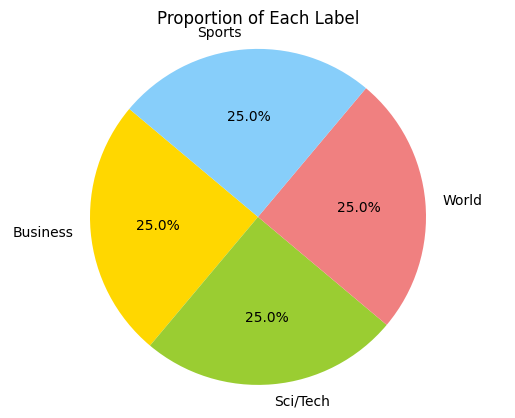

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the frequency of each label
label_counts = Counter(train_labels)

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Each Label')
plt.show()


### 2. **Feature Extraction with TF-IDF**:

We will convert the text data into numerical form using the TF-IDF vectorization technique. We will use the `Pipeline` class from scikit-learn which is really practical.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a pipeline with TF-IDF and Logistic Regression


# Fit the pipeline on the training data

In [ ]:
# Look at metrics


### 3. **Training with Cross Validation**:

We will train a linear classifier (such as Logistic Regression) using the extracted features, `Pipeline` module and cross validation with `GridSearchCV`.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter gri

# Create a GridSearchCV object

# Fit the grid search to the data


# Best parameters found by grid search
print(f'Best Parameters: {grid_search.best_params_}')

# Evaluate on the validation set


### 4. **Model Evaluation**:

We will evaluate the performance of our model on a separate test set using various metrics.

In [ ]:
metrics_val.plot()

## Part 2: LSTM Pipeline with One-Hot Encoding

In this part, we'll explore a more complex model using LSTM:

### 1. **Preprocessing for LSTM**:

We'll prepare the text data for LSTM, which involves tokenization and converting words to one-hot encoded vectors.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters


# Initialize and fit the tokenizer


# Convert texts to sequences of integers


# Pad sequences to the same length



# Assuming train_labels are integer labels


# Convert labels to one-hot vectors


### 2. **Building a Bidirectional LSTM Model**:

We'll design a neural network with a Bidirectional LSTM layer to capture context from both directions in the text.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.metrics import Precision, Recall

# Build a LSTM network

model.summary()

### 3. **Training the LSTM Model**:

We'll train our LSTM model on the preprocessed text data.


In [ ]:
#train the model


### 4. **Model Evaluation**:

*Similar* to Part 1, we will evaluate our model's performance using appropriate metrics.


In [ ]:
#predictions

# add metrics


In [ ]:
metrics_val.plot()

## Part 3: Word Embedding Add-Ons with Word2Vec

This part focuses on integrating pre-trained word embeddings into our model.

## 1. **Loading Pre-trained Word2Vec Embeddings**:

We'll load Word2Vec embeddings pre-trained on a large corpus.

In [ ]:
import gensim.downloader as api

# Download the model
word2vec_model = api.load("word2vec-google-news-300")

# Check that it's been downloaded
print(word2vec_model)

## 2. **Integrating Word2Vec into LSTM Model**:
We'll use these embeddings as inputs to our LSTM model, potentially enhancing its ability to understand context and semantics.

In [ ]:
import numpy as np

# Initialize the embedding matrix


# Define the model


model.summary()

## 3. **Training and Evaluating the Model**:
We'll train our model with these new embeddings and evaluate to see if there's an improvement in performance.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping to stop training when validation loss stops improving


# Train the model


## 4. **Model Evaluation**:

Similar to previous parts, we will evaluate our model's performance using appropriate metrics.


In [ ]:
# get predictions

#looks at metrics


## Part 4: Training Custom Embeddings with Gensim

In this final part, we'll train our own word embeddings using the Gensim library:

### 1. **Training Word2Vec/FastText with Gensim**:

We'll use the Gensim library to train Word2Vec or FastText embeddings on our corpus.

In [ ]:
from gensim.models import Word2Vec

# Initialize model

# Build vocabulary from your corpus


# Update vocabulary with pre-trained model



# Fine-tune the model on your data


### 2. **Building a Model with Custom Embeddings**:

We'll integrate these custom-trained embeddings into a new LSTM model.

In [ ]:
# Initialize the embedding matrix


# Fill in the matrix


# Build the model

model.summary()

### 3. **Model Training and Evaluation**:

We'll train this model and evaluate its performance, comparing it with the models from previous parts.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping to stop training when validation loss stops improving



# Train the model


In [ ]:
# Get the predictions

# Add metrics


### 4. Compare the embedding

We'll plot the embeddings after and before we fine-tuned on our dataset.

**Select Words for Visualization**

First, select a subset of words that you want to visualize. It's often insightful to choose words that are thematically related or words for which you expect interesting relationships or changes due to fine-tuning.

In [ ]:
# List of words you want to visualize
words = ['compagny', 'news', 'game', 'win', 'kill', 'software', 'share', 'official']

# Extract their vectors from your model
word_vectors = np.array([my_model.wv[word] for word in words if word in my_model.wv])
w2v = np.array([word2vec_model[word] for word in words if word in word2vec_model])

**Apply t-SNE to Reduce Dimensionality**

Use t-SNE to reduce the dimensionality of the word vectors to 2D for plotting. t-SNE is available through the sklearn.manifold module.

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to word vectors
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)
w2v_vectors_2d = tsne.transform(w2v)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# Scatter plot for the word vectors
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], label='fine-tuned w2v')
plt.scatter(w2v_vectors_2d[:, 0], w2v_vectors_2d[:, 1], label='w2v')

# Annotate each point in the scatter plot
for i, word in enumerate(words):
    if word in my_model.wv:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
        plt.annotate(word, xy=(w2v_vectors_2d[i, 0], w2v_vectors_2d[i, 1]))

plt.show()
